# Clustering task:

prepared by Svitlana Dubinina

Company was provided a .csv data file (sample_seaches) that includes a sample set of searches performed for flights on our websites.
- each entry row contains the user inputted search parameters - (e.g., origin, destination, departure date, return date, number of passengers, etc.).

- in addition to these search parameters, there are a number of additional columns with corresponding results to each search (e.g., cheapest total fare).

<b>Data description:</b>
1. <b>portal_id</b> - 
unique identifier assigned to each travel portal (Cheapoair, Onetravel etc.)
2. <b>searched_date</b> - 
date of search
3. <b> origin</b> - 
airport source code of origin city (start point of air journey)
4. <b> destination</b>- 
airport source code of destination city (end point of air journey)
5. <b>departure_date</b> - date&time of departure
6. <b>return_date</b>
date&time of the return
7. <b>number_of_adults</b>
number of adults entered into the search query or booked in a transaction
8. <b>number_of_children</b>
number of children entered into the search query or booked in a transaction
9. <b>number_of_seniors</b>
number of senior entered into the search query or booked in a transaction
10. <b>flight_class</b>
preferred class of flight journey put by customer during flight search
11. <b>cheapest_total_fare</b>
cheapest ticket price per search
12. <b>cheapest_engine</b>
engine which provides the cheapest tickets (GDS, SABRE etc.)
13. <b>unique_airlines</b>
possible unique bundle of airlines which carries out a flight:
 - KE - one airline; 
 - MU*AC  - 2 airlines;
 - MU * AC ** NH - 3 airlines, etc.
14. <b>country_code</b>
marketing affiliate country code
15. <b>region</b>
marketing affiliate region name
16. <b>city</b>
marketing affiliate city name

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

#for map
import plotly.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
dataset = pd.read_csv('sample_searches.csv')

In [3]:
dataset.describe()

portal_id  number_of_adults  number_of_children  number_of_seniors  \
count  25200.000000           25200.0             25200.0            25200.0   
mean     100.241667               1.0                 0.0                0.0   
std       25.687890               0.0                 0.0                0.0   
min       85.000000               1.0                 0.0                0.0   
25%       92.000000               1.0                 0.0                0.0   
50%       93.000000               1.0                 0.0                0.0   
75%       95.000000               1.0                 0.0                0.0   
max      204.000000               1.0                 0.0                0.0   

       flight_class  cheapest_total_fare  cheapest_engine  
count  25200.000000         25200.000000     25200.000000  
mean       1.026468           740.636334         6.731865  
std        0.245386          1011.618455         8.284236  
min        1.000000            25.020000         1.000000  
25%        1.000000           218.699997         1.000000  
50%        1.000000           427.650024         9.000000  
75%        1.000000           843.469978         9.000000  
max        5.000000          9999.000000       105.000000

In [4]:
dataset.tail()

portal_id searched_date origin destination departure_date return_date  \
25195        201    2017-01-14    CJS         TIJ     2017-01-15         NaN   
25196         92    2017-01-14    CJJ         LGB     2017-09-30  2017-10-08   
25197         93    2017-01-14    CJC         SCL     2017-05-20         NaN   
25198         93    2017-01-14    CJB         YYZ     2017-04-20  2017-09-26   
25199         95    2017-01-14    CJA         LIM     2017-01-21  2017-01-28   

       number_of_adults  number_of_children  number_of_seniors  flight_class  \
25195                 1                   0                  0             1   
25196                 1                   0                  0             1   
25197                 1                   0                  0             1   
25198                 1                   0                  0             1   
25199                 1                   0                  0             1   

       cheapest_total_fare  cheapest_engine  \
25195          2993.000000                1   
25196          3352.339844                1   
25197           795.289978                1   
25198          1282.170044                9   
25199           187.251602               10   

                                         unique_airlines country_code  \
25195                                              AM 4O           -    
25196                                     OZ*CA*UA*AA*KE           US   
25197                                                 LA           BE   
25198  9W  AI*AC*LH*9W  9W*EY  AI*UA*AC*LH  9W*UA*AC*...           US   
25199                                         W4  H1  LA           BE   

              region        city  
25195              -           -  
25196     NEW JERSEY  WOODBRIDGE  
25197              -           -  
25198  MASSACHUSETTS     CONCORD  
25199              -           -

In [5]:
dataset[dataset.columns.drop(['searched_date', 'departure_date', 'return_date'])] = dataset[dataset.columns.drop(['searched_date', 'departure_date', 'return_date'])].replace(['-','- '], np.nan)

In [6]:
dataset[['searched_date', 'departure_date', 'return_date']] = dataset[['searched_date', 'departure_date', 'return_date']].apply(pd.to_datetime, format='%Y-%m-%d')


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 16 columns):
portal_id              25200 non-null int64
searched_date          25200 non-null datetime64[ns]
origin                 25200 non-null object
destination            25200 non-null object
departure_date         25200 non-null datetime64[ns]
return_date            15019 non-null datetime64[ns]
number_of_adults       25200 non-null int64
number_of_children     25200 non-null int64
number_of_seniors      25200 non-null int64
flight_class           25200 non-null int64
cheapest_total_fare    25200 non-null float64
cheapest_engine        25200 non-null int64
unique_airlines        25200 non-null object
country_code           12903 non-null object
region                 10363 non-null object
city                   10363 non-null object
dtypes: datetime64[ns](3), float64(1), int64(6), object(6)
memory usage: 3.1+ MB


In [8]:
dataset.isnull().sum()

portal_id                  0
searched_date              0
origin                     0
destination                0
departure_date             0
return_date            10181
number_of_adults           0
number_of_children         0
number_of_seniors          0
flight_class               0
cheapest_total_fare        0
cheapest_engine            0
unique_airlines            0
country_code           12297
region                 14837
city                   14837
dtype: int64

In [9]:
dataset.origin.nunique()

2166

In [10]:
dataset.destination.nunique()

1587

In [11]:
dataset['totalPeopleCount'] = dataset.apply(lambda row: row['number_of_adults'] + row['number_of_children'] + row['number_of_seniors'], axis=1)
dataset.tail()

portal_id searched_date origin destination departure_date return_date  \
25195        201    2017-01-14    CJS         TIJ     2017-01-15         NaT   
25196         92    2017-01-14    CJJ         LGB     2017-09-30  2017-10-08   
25197         93    2017-01-14    CJC         SCL     2017-05-20         NaT   
25198         93    2017-01-14    CJB         YYZ     2017-04-20  2017-09-26   
25199         95    2017-01-14    CJA         LIM     2017-01-21  2017-01-28   

       number_of_adults  number_of_children  number_of_seniors  flight_class  \
25195                 1                   0                  0             1   
25196                 1                   0                  0             1   
25197                 1                   0                  0             1   
25198                 1                   0                  0             1   
25199                 1                   0                  0             1   

       cheapest_total_fare  cheapest_engine  \
25195          2993.000000                1   
25196          3352.339844                1   
25197           795.289978                1   
25198          1282.170044                9   
25199           187.251602               10   

                                         unique_airlines country_code  \
25195                                              AM 4O          NaN   
25196                                     OZ*CA*UA*AA*KE           US   
25197                                                 LA           BE   
25198  9W  AI*AC*LH*9W  9W*EY  AI*UA*AC*LH  9W*UA*AC*...           US   
25199                                         W4  H1  LA           BE   

              region        city  totalPeopleCount  
25195            NaN         NaN                 1  
25196     NEW JERSEY  WOODBRIDGE                 1  
25197            NaN         NaN                 1  
25198  MASSACHUSETTS     CONCORD                 1  
25199            NaN         NaN                 1

In [12]:
customer_country = dataset.groupby(['origin','destination', 'cheapest_total_fare', 'totalPeopleCount'])['portal_id'].aggregate('size').reset_index().sort_values('portal_id', ascending=False)
customer_country.head()

origin destination  cheapest_total_fare  totalPeopleCount  portal_id
12818    OBU         OTZ                488.0                 1         14
1478     DRG         OTZ                326.0                 1         14
19583    TNK         BET                420.0                 1         14
5481     IAN         OTZ                326.0                 1         14
8325     KVL         OTZ                326.0                 1         12

In [13]:
data = dict(type = 'choropleth', 
           locations = customer_country['destination'],
           locationmode = 'destination names',
           z = customer_country['cheapest_total_fare'], 
           text = customer_country['destination'],
           colorbar = {'title':'Destination with cheapest ticket'})

layout = dict(title = 'Destination and the cheapest ticket price', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
map1 = go.Figure(data = [data], layout=layout)
iplot(map1)

In [14]:
clust_data = customer_country.drop(['origin', 'destination'],axis=1)

In [15]:
clust_data.head()

cheapest_total_fare  totalPeopleCount  portal_id
12818                488.0                 1         14
1478                 326.0                 1         14
19583                420.0                 1         14
5481                 326.0                 1         14
8325                 326.0                 1         12

**Clustering Of DestinationCountries**

There are three parameters for clustering the destination countries by the cheapest ticket fare: cheapest_total_fare, totalPeopleCount, quantity of each travel portal, where was provided search. Since the clustering is sensitive to range of data. It is advisable to scale the data before proceeding.

In [16]:
stdSc = StandardScaler()
stdSc.fit_transform(clust_data)

array([[-2.59130535e-01,  0.00000000e+00,  3.51419552e+01],
       [-4.18065169e-01,  0.00000000e+00,  3.51419552e+01],
       [-3.25843838e-01,  0.00000000e+00,  3.51419552e+01],
       ...,
       [ 1.24657367e-01,  0.00000000e+00, -1.02960618e-01],
       [-1.91632381e-01,  0.00000000e+00, -1.02960618e-01],
       [ 6.00579269e-03,  0.00000000e+00, -1.02960618e-01]])

The following function prepared for drawing geomap with result of clustering by different algorithms.

In [17]:
def draw_geomap(data_dict, title):
    layout = dict(title = title, geo = dict(showframe = False, projection = {'type':'Mercator'}))
    current_map = dict(data = data_dict, layout = layout)
    iplot(current_map)

(1) **k-means clustering**

In general, k-means is the first choice for clustering because of its simplicity. Here the number of clusters should be defined based on the Elbow curve as an example. The clusters are formed based on the closeness to the center value of the clusters. The initial center value is chosen randomly. K-means clustering is top-down approach, in the sense, we decide the number of clusters (k) and then group the data points into k clusters.

In [18]:
clusters=range(1,10)
meanDistortions=[]
 
for k in clusters:
    model= KMeans(n_clusters=k)
    model.fit(clust_data)
    prediction=model.predict(clust_data)
    meanDistortions.append(sum(np.min(cdist(clust_data, model.cluster_centers_, 'euclidean'), axis=1)) / clust_data.shape[0])
 
#plt.cla()
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

Text(0.5,1,'Selecting k with the Elbow Method')

Looking at the plot, you can see that the knee happens at cluster=3.
That is the ideal number of clusters. So, Optimal clusters is 3.

In [19]:
#K means Clustering 
def cluster_by_Kmeans(X, nclust = 3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [20]:
clust_labels, cent = cluster_by_Kmeans(clust_data, 3)
kmeans = pd.DataFrame(clust_labels)
clust_data.insert((clust_data.shape[1]),'kmeans', kmeans)

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(clust_data['cheapest_total_fare'],clust_data['portal_id'],
                     c = kmeans[0], s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Cheapest_total_fare')
ax.set_ylabel('QPortal')

plt.colorbar(scatter)
plt.show()

In [22]:
data = [dict(type='choropleth',
             locations = customer_country['destination'],
             locationmode = 'origin names',
             z = clust_data['kmeans'],
             text = customer_country['destination'],
             colorbar = {'title':'Cluster Group'})]



draw_geomap(data, title='Grouping of Destination countries based on K-means algorithm')


(2) **Agglomerative Clustering**

Also known as Hierarchical clustering, does not require the number of clusters. Initially, each point is considered as a separate cluster, then it recursively clusters the points together depending upon the distance between them. The points are clustered in such a way that the distance between points within a cluster is minimum and distance between the cluster is maximum. Usually used distance measures are Euclidean distance, Manhattan distance or Mahalanobis distance. Unlike k-means clustering, it is "bottom-up" approach. For current investigation I will use Euclidean distance.

Additionally, providing the number of clusters is not necessary, but Python provides an option of it. Berore build Agglomerative model, I will use dendrogram for definition the number of clusters for future applying Hierarchical algorithm.

The plot of dendrogram is represented below.

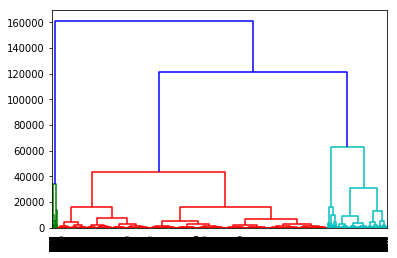

In [23]:
dendogram = sch.dendrogram(sch.linkage(clust_data, method ='ward'))

Based on this generated dendrogram I have to choose correct number of clusters regarding to principles of HC. This is our next step.
According to theoretical HC guidelines I have to find the longest vertical line avoiding horizontal line crossing. It a little bit confusing because the vertical line that match this requirement is on vertical line that match this requirement is on very left of the dendrogram. In order to be more accurate and harassing I select a vertical line that is the second longest vertical line in my dendrogram. Not so bad.  Therefore I will get only 2 clusters.

In [24]:
def cluster_by_Agglomerative(X):
    model = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(X)
    return (clust_labels1)

In [25]:
clust_labels1 = cluster_by_Agglomerative(clust_data)
agglomerative = pd.DataFrame(clust_labels1)
clust_data.insert((clust_data.shape[1]),'agglomerative',agglomerative)

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(clust_data['cheapest_total_fare'],clust_data['portal_id'],
                     c=agglomerative[0],s=50)
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('Cheapest_total_fare')
ax.set_ylabel('QPortal')

plt.colorbar(scatter)
plt.show()

In [27]:
data = [dict(type='choropleth',
             locations = customer_country['destination'],
             locationmode = 'destination names',
             z = clust_data['agglomerative'],
             text = customer_country['destination'],
             colorbar = {'title':'Cluster Group'})]

draw_geomap(data, title='Grouping of Destination countries based on Agglomerative Clustering')

So, Agglomerative algorithm was found 2 clusters. Also, interesting thing that on the geo-map there is only Brasil (BRA) was classified to the separate cluster, whereas in the K-means result Brasil was also classified to separate class, provided only one portalId(92) and with the chepeast total Fare = 3774.41.

(3) ***Guassian Mixture Modelling***

It is probabilistic based clustering or kernel density estimation based clusterig. The clusters are formed based on the Gaussian distribution of the centers.

In [33]:
def cluster_by_GMM(X, nclust=2):
    model = GaussianMixture(n_components=nclust,init_params='kmeans')
    model.fit(X)
    clust_labels3 = model.predict(X)
    return (clust_labels3)

In [34]:
clust_labels3 = cluster_by_GMM(clust_data, 2)
gmm_prediction = pd.DataFrame(clust_labels3)
clust_data['gmm_prediction'] = gmm_prediction
print('Groups Assigned : \n')
clust_data = clust_data[['cheapest_total_fare','totalPeopleCount','portal_id', 'gmm_prediction']]
clust_data.tail()

Groups Assigned : 



cheapest_total_fare  totalPeopleCount  portal_id  gmm_prediction
8166            439.570007                 1          1               0
8165            614.619995                 1          1               0
8164            879.190002                 1          1               0
8163            556.799988                 1          1               0
24277           758.250000                 1          1               0

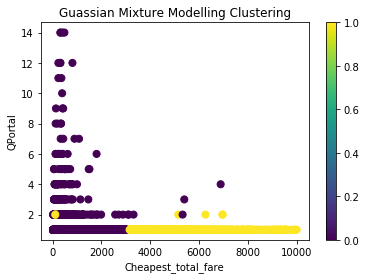

In [35]:
#Plotting the cluster obtained using GMM algorithm
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(clust_data['cheapest_total_fare'], clust_data['portal_id'],
                     c = gmm_prediction[0],s=50)
ax.set_title('Guassian Mixture Modelling Clustering')
ax.set_xlabel('Cheapest_total_fare')
ax.set_ylabel('QPortal')

plt.colorbar(scatter)
plt.show()


In [36]:
data = [dict(type='choropleth',
             locations = customer_country['destination'],
             locationmode = 'destination names',
             z = clust_data['gmm_prediction'],
             text = customer_country['destination'],
             colorbar = {'title':'Cluster Group'})]

draw_geomap(data, title='Grouping of Destination Countries based on GMM clustering')

**Summary:**

Visual analysis of heat map of clustering of destination countries shows that GMM and Agglomerative gives similar results.  k-means clustering has grouped the countries into 3 clusters which was defined based on Elbow curve.
Since clustering is unsupervised learning algorithm and since there is no clustering/target provided in the dataset, we are not able to analyse which algorithm performs better.

Otherwise, the best model for our data can be determined using metrics such as Normalized Mutual Information and Adjusted Rand Score.

**Alternative way:**
using Principal Component Analysis (PCA) instead of subsetting the variables and then perform clustering on the resultants.   